# Training the models

In [55]:
import os

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import nn
from torch.optim import Adam

from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt

import LocalLearning_copy as LocalLearning #replaced import from context because of issues with imports
# LocalLearning_copy has the KHModel_bp, that one is not implemented in context (should be though)

In [56]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [58]:
# all possible models to train 
models_path = Path("../data/models/L3UnitCIFAR10_ensemble")
file_names = os.listdir(llmodels_path)
file_names = [fn for fn in file_names if os.path.isfile(llmodels_path / Path(fn))]

In [71]:
# initilise the model
file_name = 'kh_layer_cifar10.pty' # here you choose which state
model_file = Path(file_name)
trained_state = torch.load(models_path / model_file)

modeltype = "bp" 

if modeltype == "bp": 
    model = LocalLearning.KHModel_bp
    
elif modeltype == "ll":
    model = LocalLearning.KHModel
    
khmodel = model(trained_state) # change model type here, either KHModel (ll) or KHModel_bp (bp)
khmodel.to(device)

KHModel_bp(
  (relu_h): ReLU()
  (first_dense): Linear(in_features=3072, out_features=2000, bias=True)
  (dense): Linear(in_features=2000, out_features=10, bias=False)
  (softmax): Softmax(dim=-1)
)

In [60]:
print(model_file) # double checking that the model_file is the one you want

kh_layer_cifar10.pty


# Training the model

In [61]:
# Hyper parameters:
BATCH_SIZE = 1000
NUMBER_OF_EPOCHS = 1000
LEARNING_RATE = 1e-4

# all previous models are trained with these hyper parameters

In [62]:
khmodel.train()

cifar10Train= LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=True,
    transform=ToTensor(),
    p=khmodel.pSet["p"],
)

TrainLoader = LocalLearning.DeviceDataLoader(
    cifar10Train,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True,
)

cifar10Test= LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=False,
    transform=ToTensor(),
    p=khmodel.pSet["p"],
)

TestLoader = LocalLearning.DeviceDataLoader(
    cifar10Test,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [45]:
khmodel.pSet

{'in_size': 3072,
 'hidden_size': 2000,
 'n': 4.5,
 'p': 3.0,
 'tau_l': 49999.999999999956,
 'k': 2,
 'Delta': 0.4,
 'R': 1.0}

In [63]:
ce_loss = torch.nn.CrossEntropyLoss()
AdamOpt = Adam(khmodel.parameters(), lr=LEARNING_RATE)

In [ ]:
def train(
    data: DataLoader,
    test: DataLoader,
    model: LocalLearning.KHModel, 
    loss_fn, 
    optimizer, 
    std=None,
    no_epochs=NUMBER_OF_EPOCHS,
    checkpt_period=1,
    loss_history=[],
    test_history=[],
    ):
    with tqdm(range(1, no_epochs + 1), unit="epoch") as tepoch:
        tepoch.set_description(f"Training time [epochs]")
        
        for epoch in tepoch:
            
            cumm_loss = 0.0
            model.train()
            for batch_no, (features, labels) in enumerate(data):
                preds = model(features)
                loss = loss_fn(preds, labels)
                cumm_loss += loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
            loss_history.append(cumm_loss)
            
            freq_correct = 0
            model.eval()
            for batch_no, (features, labels) in enumerate(test):
                preds = torch.argmax(model(features), dim=-1)
                freq_correct += (torch.abs(preds - labels) == 0).sum()
            
            test_history.append(freq_correct / (len(test)*test.batch_size))
    

In [76]:
loss_history = []
accuracy_history = []
#train(TrainLoader, TestLoader, khmodel, ce_loss, AdamOpt, loss_history=loss_history, test_history=accuracy_history)

save = input("Save this model? y = Yes, n = No")

if save == "y":
    torch.save(
    {
        "fkhl3-path": str(llmodels_path / model_file),
        "fkhl3-state": ll_trained_state,
        "model_state_dict": khmodel.state_dict(),
        "loss_history": loss_history,
        "accuracy_history": accuracy_history,
    },
    llmodels_path.parent / Path("KHModelCIFAR10_ensemble") / Path(modeltype + "_KHModel_" + str(model_file)),
    ) 

Save this model? y = Yes, n = Noy


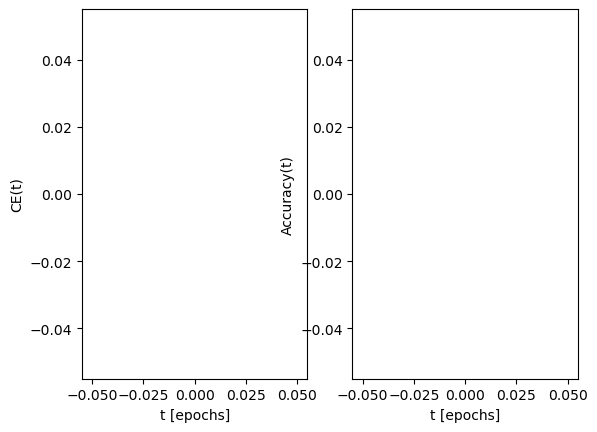

In [77]:
fig, axs = plt.subplots(1, 2)
loss_history_cpu = np.array([a.cpu().detach().numpy() for a in loss_history])
accuracy_history_cpu = np.array([a.cpu().detach().numpy() for a in accuracy_history])
axs[0].plot(loss_history_cpu)
axs[0].set_xlabel(r"t [epochs]")
axs[0].set_ylabel(r"CE(t)")
axs[1].plot(accuracy_history_cpu)
axs[1].set_xlabel(r"t [epochs]")
axs[1].set_ylabel(r"Accuracy(t)")
plt.show()